In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import requests


In [2]:
#loads the data from the csv file and puts it into a pandas dataframe and assigns the header for each column
data = pd.read_csv("vehicles.csv", header = None, skiprows=[0])
column_headers = pd.read_csv("vehicles.csv", nrows=0).columns.tolist()
data.columns = column_headers
#drops columns that arent needed
data = data.drop(["id", "url", "region_url", "VIN", "size", "image_url", "description", "county", "lat", "long"], axis=1)
#drops rows with missing values in the specified column or columns
data = data.dropna(subset=["title_status", "condition"], how='all')
data = data.dropna(subset=["year", "odometer"], how='all')
data = data.dropna(subset=["year"])


In [31]:
#Curtis cell for data cleaning

In [3]:
#Cole cell for data cleaning
#The car condition that corresponds to the title status for when it is missing
title_status_mapping = {"new" : "clean", "like new" : "clean", "excellent" : "clean", "good" : "clean", "fair" : "clean", "salvage" : "salvage" }

#function to get the year of the posting
def format_dates(old_format):
    new_format = old_format.split("-")
    return int(new_format[0])

#Funciton to fill in the missing conditons based on the odometer and title_status of the car
def fill_conditions(data_row):
    vehicle_condition = data_row["condition"]
    #if the vehicle condition isnt missing
    if pd.isna(data_row["condition"]) == False:
        vehicle_condition = data_row["condition"]
    #When the vehicle condition would be considered brand new based on its title status and odometer
    elif (data_row["title_status"] == "clean" or data_row["title_status"] == "lien" or data_row["title_status"] == "missing") and data_row["odometer"] < 500:
        vehicle_condition = "new"
    #When the vehicle condition would be considered like new based on its title status and odometer
    elif (data_row["title_status"] == "clean" or data_row["title_status"] == "lien" or data_row["title_status"] == "missing") and data_row["odometer"] < 5000:
        vehicle_condition = "like new"
    #When the vehicle condition would be considered excellent based on its title status and odometer
    elif (data_row["title_status"] == "clean" or data_row["title_status"] == "lien" or data_row["title_status"] == "missing") and data_row["odometer"] < 50000:
        vehicle_condition = "excellent"
    #When the vehicle condition would be considered good based on its title status and odometer
    elif (data_row["title_status"] == "clean" or data_row["title_status"] == "lien" or data_row["title_status"] == "missing") and data_row["odometer"] < 150000:
        vehicle_condition = "good"
    #When the vehicle condition would be considered fair based on its title status and odometer
    elif (data_row["title_status"] == "clean" or data_row["title_status"] == "lien" or data_row["title_status"] == "missing") and data_row["odometer"] <= 220000:
        vehicle_condition = "fair"
    # when it doesnt fall into one of the above categories then its condition is assumed to be salvage
    else:
        vehicle_condition = "salvage"
    return vehicle_condition

data["fuel"] = data["fuel"].fillna(value="gas") #Fills the missing fuel column values with gas
#fills the missing values in the title_status column based on the title_status_mapping dictionary
data["title_status"] = data["title_status"].fillna(value=data["condition"].map(title_status_mapping))
data["posting_date"] = data["posting_date"].apply(format_dates) #formats the posting date to just be the year
#fills in missing values in the odometer column by taking the number of years the car has existed to estimate the total distance driven based on an average usage of 20000 per year
data["odometer"] = data["odometer"].fillna(value=(data["posting_date"] - data["year"]) * 20000)
data["condition"] = data.apply(fill_conditions, axis=1) #fills in missing values in the condition column based on fill_condition function

<Figure size 432x288 with 0 Axes>

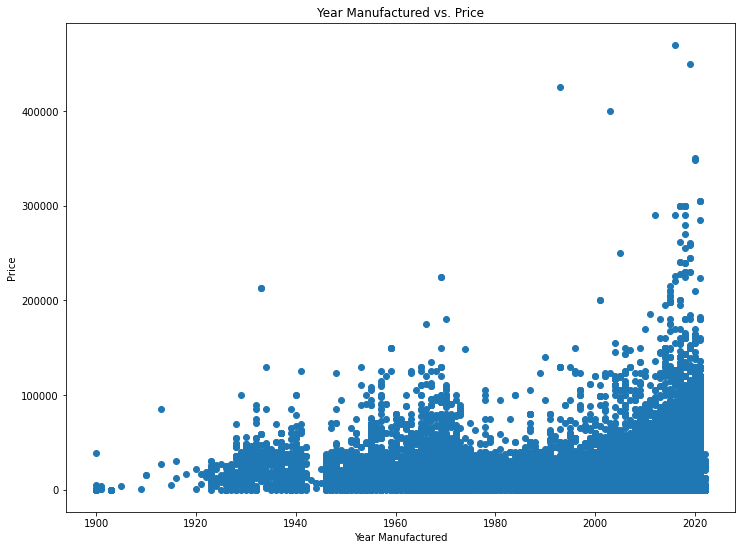

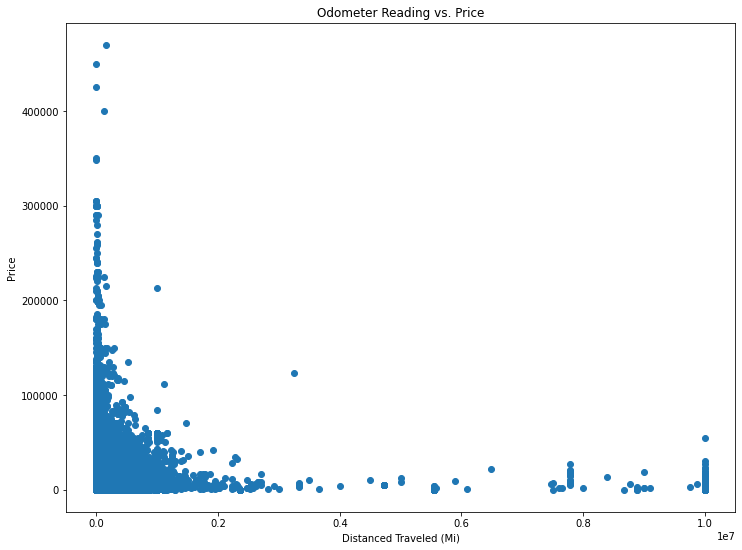

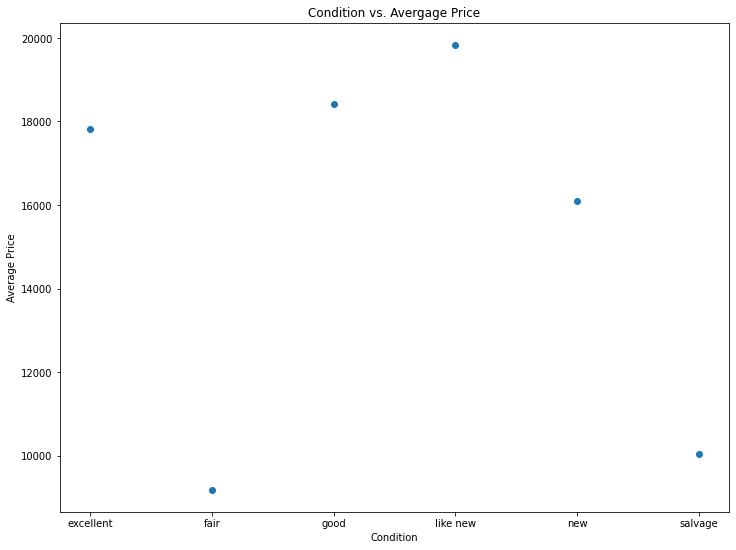

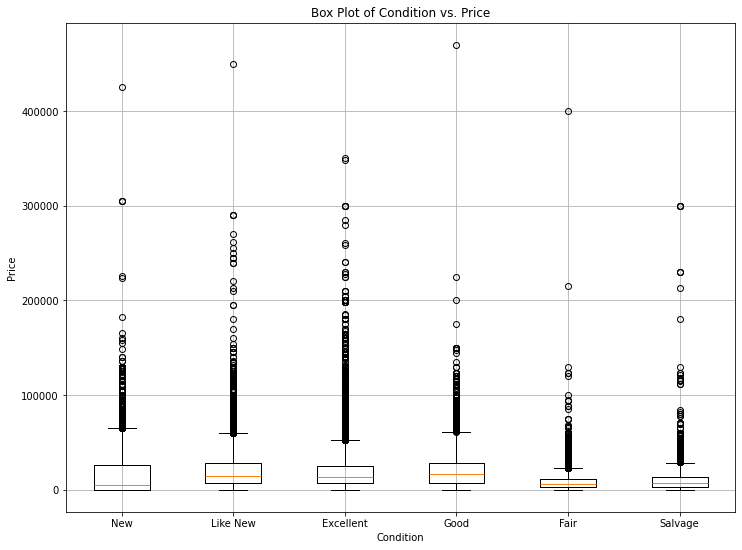

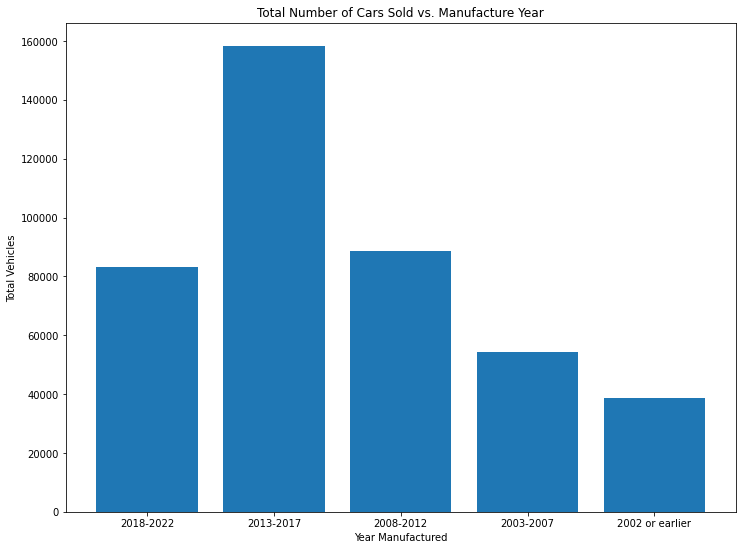

In [4]:
#code for analysis
data = data[data["price"] < 500000] #remove rows from the data where the price of the car is greater then 500000 since it is likely an outlier

#creates scatter plot of the year the car was manufactured vs the price it was sold for
plt.figure(1)
plt.figure(figsize=(12, 9))
plt.scatter(data["year"], data["price"])
plt.title("Year Manufactured vs. Price")
plt.ylabel("Price")
plt.xlabel("Year Manufactured")

#creates a scatter plot of the distance that the car has travelled vs the price it was sold for
plt.figure(2)
plt.figure(figsize=(12, 9))
plt.scatter(data["odometer"], data["price"])
plt.title("Odometer Reading vs. Price")
plt.ylabel("Price")
plt.xlabel("Distanced Traveled (Mi)")

#creates a scatter plot of the avergae price a car sold for based on its condition
plt.figure(3)
plt.figure(figsize=(12, 9))
plt.scatter(list(data.groupby("condition")["price"].groups.keys()), data.groupby("condition")["price"].mean().tolist())
plt.title("Condition vs. Avergage Price")
plt.ylabel("Average Price")
plt.xlabel("Condition")

#creates a box plot of the condition that a car is in and what it was sold for
plt.figure(4)
plt.figure(figsize=(12, 9))
#groups the data based on the condition that the car is in
new_condition = data.loc[data["condition"] == "new", ['price']]
like_new_condition = data.loc[data["condition"] == "like new", ['price']]
excellent_condition = data.loc[data["condition"] == "excellent", ['price']]
good_condition = data.loc[data["condition"] == "good", ['price']]
fair_condition = data.loc[data["condition"] == "fair", ['price']]
salvage_condition = data.loc[data["condition"] == "salvage", ['price']]
plt.boxplot([new_condition["price"], like_new_condition["price"], excellent_condition["price"], good_condition["price"], fair_condition["price"], salvage_condition["price"]])
plt.xticks([1, 2, 3, 4, 5, 6],["New", "Like New", "Excellent", "Good", "Fair", "Salvage"])

plt.title("Box Plot of Condition vs. Price")
plt.ylabel("Price")
plt.xlabel("Condition")
plt.grid(True)

#creates a bar chart for the total number of cars sold based on a 5 year manufacturer peried
plt.figure(5)
plt.figure(figsize=(12, 9))
x = np.array(["2018-2022", "2013-2017", "2008-2012", "2003-2007", "2002 or earlier"])
y = np.array([
    data[data["year"] > 2017]["year"].shape[0], 
    data[(data["year"] <= 2017) & (data["year"] > 2012)]["year"].shape[0], 
    data[(data["year"] <= 2012) & (data["year"] > 2007)]["year"].shape[0], 
    data[(data["year"] <= 2007) & (data["year"] > 2002)]["year"].shape[0],
    data[data["year"] <= 2002]["year"].shape[0]
])

plt.title("Total Number of Cars Sold vs. Manufacture Year")
plt.ylabel("Total Vehicles")
plt.xlabel("Year Manufactured")
plt.bar(x,y)

# Display the plot
plt.show()

In [39]:
#code for model

In [40]:
#code for validation